## Setup

In [2]:
import os

In [3]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
print(IN_COLAB)

True


In [4]:
!pip install graph_nets  dm-sonnet tensorflow_probability

In [5]:
if IN_COLAB and 'drive' not in os.listdir("/content"):
    from google.colab import drive

    drive.mount('/content/drive')

In [6]:
if IN_COLAB:
    os.chdir('/content/drive/MyDrive/bakalarka')

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import sonnet as snt
import networkx as nx
import numpy as np

import functools
import json
import os
import enum
import collections
import time

from graph_nets import blocks

from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf


In [8]:
params = dict(noise=0.02, gamma=1.0, field='velocity', history=False,
              size=2, batch=2)

In [9]:
from common import NodeType

## Data Loading

In [10]:
data_path = 'data/airfoil'

In [11]:
# todo add citation
def _parse(proto, meta):
    """Parses a trajectory from tf.Example."""
    feature_lists = {k: tf.io.VarLenFeature(tf.string)
                     for k in meta['field_names']}
    features = tf.io.parse_single_example(proto, feature_lists)
    out = {}
    for key, field in meta['features'].items():
        data = tf.io.decode_raw(features[key].values, getattr(tf, field['dtype']))
        data = tf.reshape(data, field['shape'])
        if field['type'] == 'static':
            data = tf.tile(data, [meta['trajectory_length'], 1, 1])
        elif field['type'] == 'dynamic_varlen':
            length = tf.io.decode_raw(features['length_' + key].values, tf.int32)
            length = tf.reshape(length, [-1])
            data = tf.RaggedTensor.from_row_lengths(data, row_lengths=length)
        elif field['type'] != 'dynamic':
            raise ValueError('invalid data format')
        out[key] = data
    return out

In [12]:
# todo add citation
def load_dataset(path, split):
    """Load dataset."""
    with open(os.path.join(path, 'meta.json'), 'r') as fp:
        meta = json.loads(fp.read())
    ds = tf.data.TFRecordDataset(os.path.join(path, split + '.tfrecord'))
    ds = ds.map(functools.partial(_parse, meta=meta), num_parallel_calls=8)
    ds = ds.prefetch(1)
    return ds

In [13]:
# todo add citation
def split_and_preprocess(ds, noise_field, noise_scale, noise_gamma):
    """Splits trajectories into frames, and adds training noise."""

    def add_noise(frame):
        noise = tf.random.normal(tf.shape(frame[noise_field]),
                                 stddev=noise_scale, dtype=tf.float32)
        # don't apply noise to boundary nodes
        mask = tf.equal(frame['node_type'], NodeType.NORMAL)
        noise = tf.where(mask, noise, tf.zeros_like(noise))
        frame[noise_field] += noise
        frame['target|' + noise_field] += (1.0 - noise_gamma) * noise
        return frame

    ds = ds.flat_map(tf.data.Dataset.from_tensor_slices)
    ds = ds.map(add_noise, num_parallel_calls=8)
    ds = ds.shuffle(10000)
    ds = ds.repeat(None)
    return ds.prefetch(10)

In [14]:
# todo add citation
def add_targets(ds, fields, add_history):
    """Adds target and optionally history fields to dataframe."""

    def fn(trajectory):
        out = {}
        for key, val in trajectory.items():
            out[key] = val[1:-1]
            if key in fields:
                if add_history:
                    out['prev|' + key] = val[0:-2]
                out['target|' + key] = val[2:]
        return out

    return ds.map(fn, num_parallel_calls=8)

In [15]:
ds = load_dataset(data_path, "small")
ds = add_targets(ds, [params['field']], add_history=params['history'])

In [16]:
ds = split_and_preprocess(ds, noise_field=params['field'],
                          noise_scale=params['noise'],
                          noise_gamma=params['gamma'])

## Prepare for learning

In [17]:
d = iter(ds).next()

In [18]:
def triangles_to_edges(faces):
    """Computes mesh edges from triangles."""
    # collect edges from triangles
    edges = tf.concat([faces[:, 0:2],
                       faces[:, 1:3],
                       tf.stack([faces[:, 2], faces[:, 0]], axis=1)], axis=0)
    # those edges are sometimes duplicated (within the mesh) and sometimes
    # single (at the mesh boundary).
    # sort & pack edges as single tf.int64
    receivers = tf.reduce_min(edges, axis=1)
    senders = tf.reduce_max(edges, axis=1)
    packed_edges = tf.bitcast(tf.stack([senders, receivers], axis=1), tf.int64)
    # remove duplicates and unpack
    unique_edges = tf.bitcast(tf.unique(packed_edges)[0], tf.int32)
    senders, receivers = tf.unstack(unique_edges, axis=1)
    # create two-way connectivity
    return (tf.concat([senders, receivers], axis=0),
            tf.concat([receivers, senders], axis=0))


In [19]:
NodeTypeCnt = tf.unique(tf.reshape(d['node_type'], d['node_type'].shape[:1])).y.shape[0]

In [20]:
@tf.function
def toGraphsTuple(d):
    send, recive = triangles_to_edges(d['cells'])
    rel_pos = (tf.gather(d['mesh_pos'], send) - tf.gather(d['mesh_pos'], recive))
    nodes_unique = tf.unique_with_counts(tf.reshape(d["node_type"], [-1]))
    dd = {
        #"nodes": tf.concat([d["velocity"],d["pressure"],d["density"],tf.cast(d["node_type"],tf.float32),d["mesh_pos"]],1),
        "nodes": tf.concat([d['velocity'], tf.one_hot(nodes_unique.idx, NodeTypeCnt, dtype=tf.float32)], 1),
        # on change update loss function ^
        "senders": send,
        "receivers": recive,
        "edges": tf.concat([
            rel_pos,
            tf.norm(rel_pos, axis=-1, keepdims=True)], 1)
    }
    return utils_tf.data_dicts_to_graphs_tuple([dd])

In [21]:
dd = toGraphsTuple(d)
LINEAR_FEATURES = dd.nodes.shape[1] - NodeTypeCnt

In [22]:
itr = iter(ds)
aa = itr.next()

## Model and loss function

In [23]:
from Normalizer import Normalizer

In [24]:
from EncodeProcessDecodeBasic import EncodeProcessDecode

In [25]:
from EncodeProcessDecodeNorm import EncodeProcessDecode as EncodeProcessDecodeNorm

In [26]:
models = {"basic": {"model": EncodeProcessDecode,
                    "args": {"steps": 15,
                             "learn_features": 2,
                             "node_net_sizes": [128] * 2 + [2],
                             "edge_net_sizes": [128] * 2 + [4]}},
          "small_test": {"model": EncodeProcessDecode,
                         "args": {"steps": 5,
                                  "learn_features": 2,
                                  "node_net_sizes": [8] * 2 + [2],
                                  "edge_net_sizes": [8] * 2 + [4]}},
          "full": {"model": EncodeProcessDecodeNorm,
                   "args": {"steps": 15,
                            "learn_features": 2,
                            "n_layers": 2,
                            "lat_size": 128,
                            "edge_feat_cnt": 3,
                            "node_feat_cnt": 5}}}

### Model hyperparameters

In [28]:
from AdamModLr import Adam

lr = 1e-4
# opt = snt.optimizers.Adam(lr)
opt = Adam(lr)
steps = 15
#model = EncodeProcessDecode(steps, LINEAR_FEATURES, [128] * 2, [128] * 2 + [4])
mod = "full"
md = models[mod]
model = md["model"](**md["args"])
initial_learning_rate = lr
decay_rate = 0.1
decay_steps = 5e6
learning_increase = 1e-6

## Training

In [29]:
dd

GraphsTuple(nodes=<tf.Tensor: shape=(5233, 5), dtype=float32, numpy=
array([[101.07495 ,  11.608115,   1.      ,   0.      ,   0.      ],
       [106.54282 ,  15.215259,   1.      ,   0.      ,   0.      ],
       [110.38941 ,  15.887845,   1.      ,   0.      ,   0.      ],
       ...,
       [114.82647 ,  39.039078,   0.      ,   0.      ,   1.      ],
       [114.7628  ,  38.94197 ,   0.      ,   0.      ,   1.      ],
       [114.7625  ,  39.004017,   0.      ,   0.      ,   1.      ]],
      dtype=float32)>, edges=<tf.Tensor: shape=(30898, 3), dtype=float32, numpy=
array([[ 0.00579996, -0.01206488,  0.01338659],
       [-0.00720367, -0.01440071,  0.01610196],
       [-0.00630522,  0.0145334 ,  0.0158422 ],
       ...,
       [ 0.30951977,  1.4802246 ,  1.5122392 ],
       [ 1.0828505 ,  1.8325498 ,  2.1285684 ],
       [-0.43042946,  1.2830333 ,  1.3533084 ]], dtype=float32)>, receivers=<tf.Tensor: shape=(30898,), dtype=int32, numpy=array([  69,   55,  159, ..., 5061, 5106, 5109],

In [30]:
def decayed_learning_rate(step):
    return initial_learning_rate * decay_rate ** (step / decay_steps) + learning_increase

In [31]:
@tf.function
def update_step(data):
    print("Tracing!")
    grp = toGraphsTuple(data)
    with tf.GradientTape() as tape:
        los = model.loss(grp,data) #change to loss

    gradients = tape.gradient(los, model.trainable_variables)

    opt.apply(gradients, model.trainable_variables)  # sonnet optimizer
    return los

In [32]:
update_step(aa);

Tracing!
Tracing!


In [33]:
chck_root = "models/full/"
chck_name = mod

chck = tf.train.Checkpoint(module=model)

latest = tf.train.latest_checkpoint(chck_root)
if latest is not None:
    print("loading", latest)
    chck.restore(latest)

In [34]:
if latest is None and isinstance(model, EncodeProcessDecodeNorm):
    print("Acumulating")
    for i in range(1000):
      data = itr.next()
      grp = toGraphsTuple(data)
      model.loss(grp,data)

Acumulating


In [35]:
t = time.time()
for i in range(int(1e7)):
    a = itr.next()
    m = update_step(a)
    if i % 500 == 0:
        opt.learning_rate.assign(decayed_learning_rate(i))
        print("i", i, "mse:", m.numpy())
        if i and i % 40000 == 0:
            chck.save(chck_root + chck_name)
print(time.time() - t)

i 0 mse: 0.39315826
5.165788412094116


In [36]:
m.numpy()

0.11630739

## Vizualization

In [37]:
dt2 = load_dataset(data_path, "small")
qq = iter(dt2).next()
qqq = {}
for i, j in qq.items():
    qqq[i] = j[0]
grp_ = toGraphsTuple(qqq)

In [38]:
@tf.function
def toGraphsTupleOld(d):
    send, recive = triangles_to_edges(d['cells'])
    rel_pos = (tf.gather(d['mesh_pos'], send) - tf.gather(d['mesh_pos'], recive))
    nodes_unique = tf.unique_with_counts(tf.reshape(d["node_type"], [-1]))
    dd = {
        #"nodes": tf.concat([d["velocity"],d["pressure"],d["density"],tf.cast(d["node_type"],tf.float32),d["mesh_pos"]],1),
        "nodes": tf.concat([d['velocity'], tf.one_hot(tf.reshape(d["node_type"], [-1]), NodeTypeCnt, dtype=tf.float32)],
                           1),  # on change update loss function ^
        "senders": send,
        "receivers": recive,
        "edges": tf.concat([
            rel_pos,
            tf.norm(rel_pos, axis=-1, keepdims=True)], 1)
    }
    return utils_tf.data_dicts_to_graphs_tuple([dd])

In [39]:
# fix mistake in data preparation
if chck_root == "models/new":
  grp_ = toGraphsTupleOld(qqq)

In [40]:
res = [grp_, ]
loss_mask = tf.logical_or(tf.equal(qqq['node_type'][:, 0], NodeType.NORMAL),
                          tf.equal(qqq['node_type'][:, 0], NodeType.OUTFLOW))
loss_mask = tf.reshape(tf.concat([loss_mask for _ in range(5)], -1), [-1, 5])
for i in range(600):
    grp2_ = model(grp_,False)
    grp_ = grp_.replace(nodes=tf.where(loss_mask, grp2_.nodes, grp_.nodes))
    res.append(grp_)

In [41]:
grp_.nodes.shape, grp2_.nodes.shape, loss_mask.shape

(TensorShape([5233, 5]), TensorShape([5233, 5]), TensorShape([5233, 5]))

In [42]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import tri as mtri

In [43]:
res[0]

GraphsTuple(nodes=<tf.Tensor: shape=(5233, 5), dtype=float32, numpy=
array([[329.58823 ,  43.988186,   1.      ,   0.      ,   0.      ],
       [298.48862 ,  43.94016 ,   1.      ,   0.      ,   0.      ],
       [299.17093 ,  43.484436,   1.      ,   0.      ,   0.      ],
       ...,
       [257.09155 ,  74.75611 ,   0.      ,   0.      ,   1.      ],
       [257.09155 ,  74.75611 ,   0.      ,   0.      ,   1.      ],
       [257.09155 ,  74.75611 ,   0.      ,   0.      ,   1.      ]],
      dtype=float32)>, edges=<tf.Tensor: shape=(30898, 3), dtype=float32, numpy=
array([[ 0.00579996, -0.01206488,  0.01338659],
       [-0.00720367, -0.01440071,  0.01610196],
       [-0.00630522,  0.0145334 ,  0.0158422 ],
       ...,
       [ 0.30951977,  1.4802246 ,  1.5122392 ],
       [ 1.0828505 ,  1.8325498 ,  2.1285684 ],
       [-0.43042946,  1.2830333 ,  1.3533084 ]], dtype=float32)>, receivers=<tf.Tensor: shape=(30898,), dtype=int32, numpy=array([  69,   55,  159, ..., 5061, 5106, 5109],

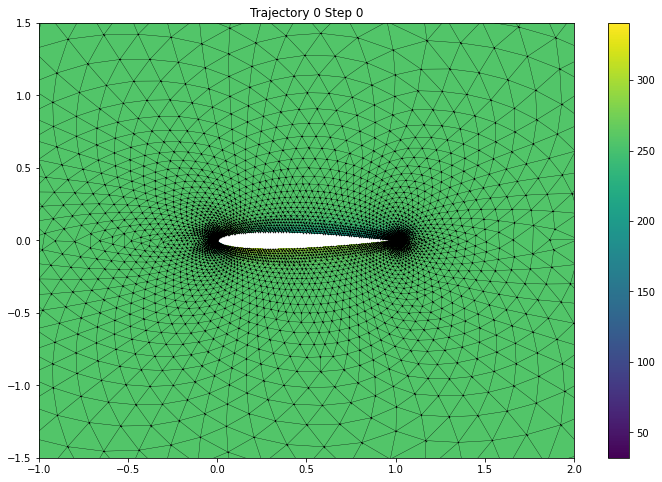

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
skip = 5
num_steps = len(res)
num_frames = num_steps // skip
# compute bounds
bounds = []
bb_min, bb_max = tf.reduce_min(qq['velocity'][:, 0]), tf.reduce_max(qq['velocity'][:, 0])


def animate(num):
    global t
    step = (num * skip) % num_steps
    traj = (num * skip) // num_steps
    ax.cla()
    ax.set_xlim(-1, 2)
    ax.set_ylim(-1.5, 1.5)
    ax.set_autoscale_on(False)
    vmin, vmax = bb_min, bb_max
    pos = qqq['mesh_pos']
    faces = qqq['cells']
    velocity = res[step].nodes[..., :2].numpy()
    triang = mtri.Triangulation(pos[:, 0], pos[:, 1], faces)
    t = ax.tripcolor(triang, velocity[:, 0], vmin=vmin, vmax=vmax)
    ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
    ax.set_title('Trajectory %d Step %d' % (traj, step))
    return fig,


animate(0)
plt.colorbar(t)

anim = FuncAnimation(fig, animate, frames=num_frames, interval=200)
from IPython.display import HTML

HTML(anim.to_html5_video())

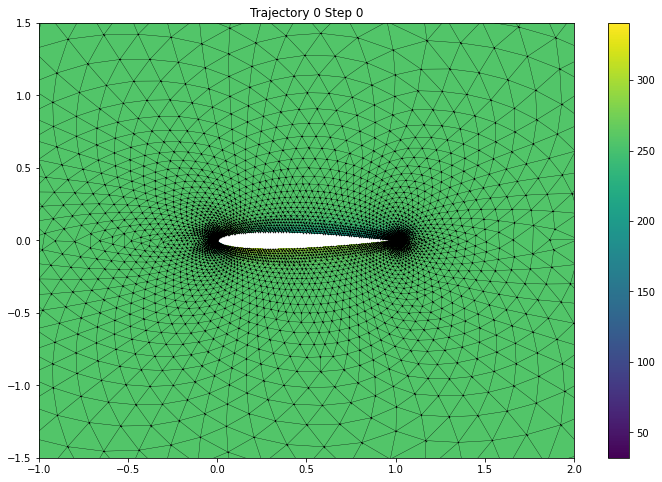

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
skip = 5
num_steps = len(res)
num_frames = num_steps // skip
# compute bounds
bounds = []

bb_min, bb_max = tf.reduce_min(qq['velocity'][:, 0]), tf.reduce_max(qq['velocity'][:, 0])


def animate(num):
    global t
    step = (num * skip) % num_steps
    traj = (num * skip) // num_steps
    ax.cla()
    ax.set_xlim(-1, 2)
    ax.set_ylim(-1.5, 1.5)
    ax.set_autoscale_on(False)
    vmin, vmax = bb_min, bb_max
    pos = qq['mesh_pos'][0]
    faces = qq['cells'][0]
    velocity = qq['velocity'][step]
    triang = mtri.Triangulation(pos[:, 0], pos[:, 1], faces)
    t = ax.tripcolor(triang, velocity[:, 0], vmin=vmin, vmax=vmax)
    ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
    ax.set_title('Trajectory %d Step %d' % (traj, step))
    return fig,


animate(0)
plt.colorbar(t)

anim = FuncAnimation(fig, animate, frames=num_frames, interval=200)
from IPython.display import HTML

HTML(anim.to_html5_video())

In [46]:
bb_min, bb_max

(<tf.Tensor: shape=(), dtype=float32, numpy=31.879688>,
 <tf.Tensor: shape=(), dtype=float32, numpy=340.60352>)